 # Financial Inclusion in Africa

##**BLUF (Bottom line up front)**

Financial inclusion remains one of the main obstacles to economic and human development in Africa. For example, across Kenya, Rwanda, Tanzania, and Uganda only 9.1 million adults (or 14% of adults) have access to or use a commercial bank account.

Traditionally, access to bank accounts has been regarded as an indicator of financial inclusion. Despite the proliferation of mobile money in Africa, and the growth of innovative fintech solutions, banks still play a pivotal role in facilitating access to financial services. Access to bank accounts enable households to save and make payments while also helping businesses build up their credit-worthiness and improve their access to loans, insurance, and related services. Therefore, access to bank accounts is an essential contributor to long-term economic growth.

The objective of this competition is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key factors driving individuals’ financial security.

## Load dataset

In [57]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [58]:
# Data
train=pd.read_csv('data\Train.csv')
test=pd.read_csv('data\Test.csv')
variables=pd.read_csv('data\VariableDefinitions.csv')


print('shape of Train dataset',train.shape)
print('shape of Test dataset',test.shape)

shape of Train dataset (23524, 13)
shape of Test dataset (10086, 12)


13 variables in the train dataset and 12 variables in test dataset

In [59]:
train.tail()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
23519,Uganda,2018,uniqueid_2113,No,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income
23520,Uganda,2018,uniqueid_2114,No,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income
23521,Uganda,2018,uniqueid_2115,No,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income
23522,Uganda,2018,uniqueid_2116,No,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed
23523,Uganda,2018,uniqueid_2117,No,Rural,Yes,10,20,Male,Child,Single/Never Married,Secondary education,No Income


In [60]:
# Variables explanation
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


## Data preprocessing

In [61]:
#check data types
print(train.info())
# check missing values
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None
country                   0
year                      0

In [62]:
# check duplicates
print('Duplicated values:',train.duplicated().sum())

Duplicated values: 0


There no missing values and duplicated values

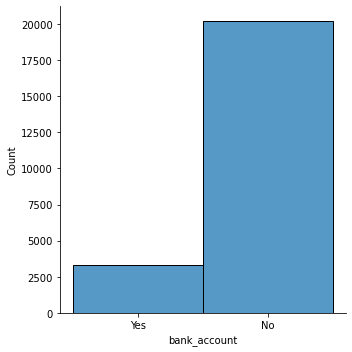

In [63]:
# target variable distribution
sns.displot(train.bank_account)

## Modeling

### Label Encoding

Convert the target variables into numerical

In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert label
le=LabelEncoder()
train['bank_account']=le.fit_transform(train['bank_account'])
train.head(1)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed


In [65]:
# separate features from the target
X=train.drop(columns='bank_account')
y=train.loc[:,'bank_account']

y

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int32

The target values have been transformed into numerical datatypes, **1** represents **‘Yes’** and **0** represents **‘No’**.

In [66]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    le=LabelEncoder()
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    return data                  

In [67]:
# preprocess the train data 
processed_train = preprocessing_data(X)
processed_test = preprocessing_data(test)

In [68]:
processed_train.shape

(23524, 37)

Now we have more independent variables than before (37 variables). This doesn’t mean all these variables are important to train our model. You need to select only important features that can increase the performance of the model.

In [69]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(processed_train,y, stratify=y, test_size=0.1,random_state=42)

Only 10% of the train dataset will be used for evaluating the models.

In [70]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_train,y_train)
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_test)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_test, xg_y_model))

Error rate of XGB classifier:  0.10752231194220141


c:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


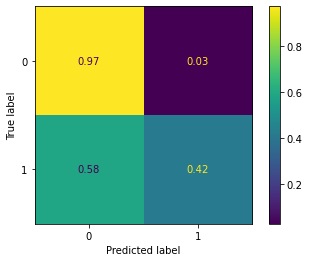

In [71]:
from sklearn.metrics import plot_confusion_matrix

# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(xg_model,X_test, y_test,normalize='true')

Our XGBoost model performs well on predicting **class 0** and performs poorly on predicting **class 1**. Model performance may be influenced by data imbalance (Undersampled or Oversampled). We can SMOTE to fix the imbalance

One way to increase the model performance is by applying the Grid search method as an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. 

In [72]:
# Fix data imbalance
# Too few instances to undersample (nmeed to preserve data)
# Try SMOTE

import imblearn
print("imblearn version: ", imblearn.__version__)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2468)
X_SMOTE, y_SMOTE = sm.fit_resample(processed_train, y)

print("Shape before SMOTE: ", X.shape, y.shape, "\n")
print("Shape after SMOTE: ", X_SMOTE.shape, y_SMOTE.shape, "\n")

imblearn version:  0.9.0
Shape before SMOTE:  (23524, 12) (23524,) 

Shape after SMOTE:  (40424, 37) (40424,) 



In [75]:
X_train, X_test, y_train, y_test=train_test_split(X_SMOTE,y_SMOTE, stratify=y_SMOTE, test_size=0.1,random_state=42)

In [76]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_train,y_train)
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_test)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_test, xg_y_model))

Error rate of XGB classifier:  0.07321296067276772


Our model error has improved from 0.1 to 0.07 after imbalance

c:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


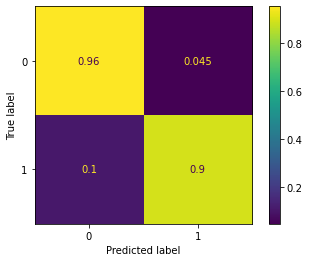

In [77]:
from sklearn.metrics import plot_confusion_matrix

# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(xg_model,X_test, y_test,normalize='true')

Our model has improved. 

In [81]:
# Get the predicted result for the test Data
test.bank_account = xg_model.predict(processed_test)

C:\Users\User\AppData\Local\Temp/ipykernel_5604/147371832.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.bank_account = xg_model.predict(processed_test)


In [82]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

In [83]:
submission.head(5)

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,1
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,1


In [84]:
# Create submission csv file csv file
submission.to_csv('data\kiboi_submission.csv', index = False)